In [1]:
# !pip install nsepy 2>&1 > /dev/null
!pip install pycaret 2>&1 > /dev/null
!pip install plotly==5.5.0

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#import 
import pandas as pd
import json
import datetime as dt
# from nsepy import get_history as stock_hist
import numpy as np
from pycaret.regression import *
from matplotlib import pyplot as plt

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [4]:
#Utils functions
def read_json(file_path):
    with open(file_path, "r") as f:
        return json.load(f)
    
def date_parser(dt):
    dt = dt.split(',')
    year = int(dt[0])
    month = int(dt[1])
    day = int(dt[2])
    return year, month, day

In [5]:
config_file = read_json('/content/drive/MyDrive/Colab Notebooks/Stock_Prediction/config.json')

In [6]:
symbol = config_file['symbol']

y, m, d = date_parser(config_file['train_start_date'])
train_start_date = dt.datetime(y,m,d)

y, m, d = date_parser(config_file['train_end_date'])
train_end_date = dt.datetime(y,m,d)

y, m, d = date_parser(config_file['test_start_date'])
test_start_date = dt.datetime(y,m,d)

y, m, d = date_parser(config_file['test_end_date'])
test_end_date = dt.datetime(y,m,d)

In [7]:
#Setting start and end dates and fetching the historical data

# stk_data = stock_hist(symbol=symbol,start=train_start_date,end=test_end_date) #considering both train and test data
stk_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Stock_Prediction/SBIN_dataset.csv')
stk_data['Date'] = pd.to_datetime(stk_data['Date'])

In [8]:
stk_data.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2015-01-01,SBIN,EQ,311.85,312.45,315.00,310.70,314.0,314.00,313.67,6138488,1.925489e+14,58688,1877677,0.3059
1,2015-01-02,SBIN,EQ,314.00,314.35,318.30,314.35,315.6,315.25,316.80,9935094,3.147389e+14,79553,4221685,0.4249
2,2015-01-05,SBIN,EQ,315.25,316.25,316.80,312.10,312.8,312.75,313.84,9136716,2.867432e+14,88236,3845173,0.4208
3,2015-01-06,SBIN,EQ,312.75,310.00,311.10,298.70,299.9,299.90,305.14,15329257,4.677601e+14,169268,7424847,0.4844
4,2015-01-07,SBIN,EQ,299.90,300.00,302.55,295.15,301.4,300.15,299.95,15046745,4.513243e+14,147185,5631400,0.3743


In [9]:
# stk_data['Date'] = stk_data.index
stk_data.index = stk_data['Date']
data = pd.DataFrame(columns = ['Open'])
data['Open'] = stk_data['Open']
data.head()

,Open
Date,
2015-01-01,312.45
2015-01-02,314.35
2015-01-05,316.25
2015-01-06,310.00
2015-01-07,300.00


In [10]:
# # create 12 month moving average
# # data['MA12'] = data['Open'].rolling(12).mean()
# # plot the data and MA
# import plotly.express as px
# fig = px.line(data, x='Date', y=["Open"], template = 'plotly_dark')
# fig.show()

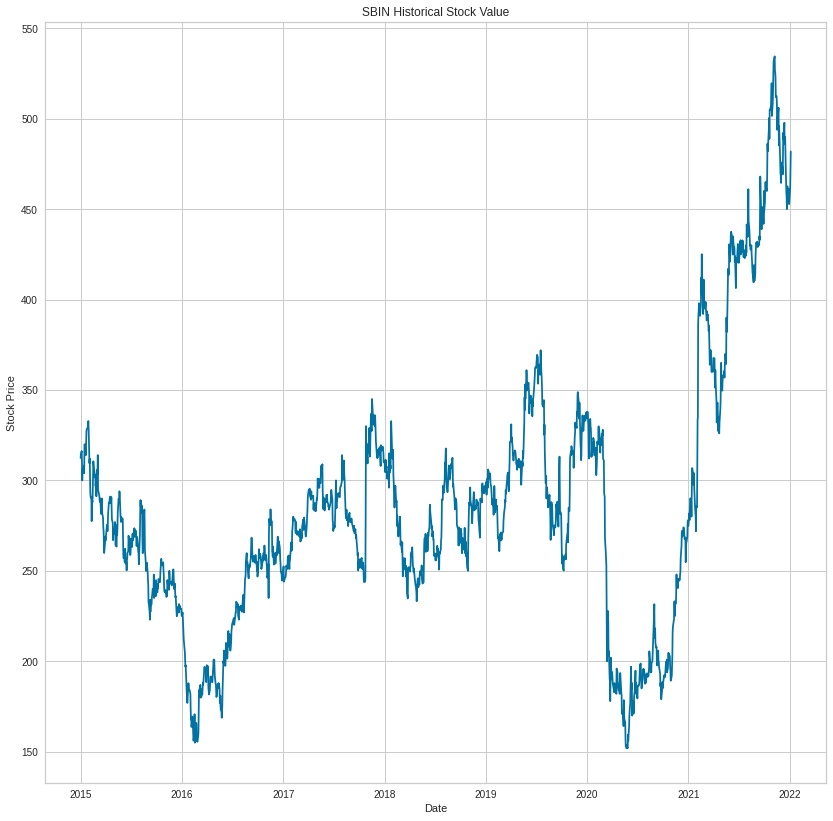

In [11]:
plt.figure(figsize=(14,14))
plt.plot(data["Open"])
plt.title(f'{symbol} Historical Stock Value')
plt.xlabel("Date")
plt.ylabel('Stock Price')
plt.show()

In [12]:
# extract month and year from dates
data['Date'] = data.index
data['Month'] = [i.month for i in data['Date']]
data['Year'] = [i.year for i in data['Date']]
data['Day_of_week'] = [i.dayofweek for i in data['Date']]
data['Day_of_year'] = [i.dayofyear for i in data['Date']]
# create a sequence of numbers
# data['Series'] = np.arange(1,len(data)+1)
# drop unnecessary columns and re-arrange
data = data[['Year', 'Month','Day_of_week','Day_of_year','Open']] 
# check the head of the dataset
data.head()

,Year,Month,Day_of_week,Day_of_year,Open
Date,,,,,
2015-01-01,2015,1,3,1,312.45
2015-01-02,2015,1,4,2,314.35
2015-01-05,2015,1,0,5,316.25
2015-01-06,2015,1,1,6,310.00
2015-01-07,2015,1,2,7,300.00


In [13]:
data.tail()

,Year,Month,Day_of_week,Day_of_year,Open
Date,,,,,
2021-12-30,2021,12,3,364,452.75
2021-12-31,2021,12,4,365,454.25
2022-01-03,2022,1,0,3,462.00
2022-01-04,2022,1,1,4,472.50
2022-01-05,2022,1,2,5,481.90


In [15]:
# split data into train-test set
train = data[data['Year'] < 2020]
test = data[ data['Year'] >= 2020]
# check shape
train.shape, test.shape


((1234, 5), (503, 5))

In [16]:
# initialize setup
s = setup(data = train, test_data = test, target = 'Open', fold_strategy = 'timeseries', 
          numeric_features = ['Year', 'Month','Day_of_week','Day_of_year',], fold = 5, transform_target = True, session_id = 123)

,Description,Value
0,session_id,123
1,Target,Open
2,Original Data,"(1234, 5)"
3,Missing Values,False
4,Numeric Features,4
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1234, 3)"


In [17]:
best = compare_models(sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
llar,Lasso Least Angle Regression,31.8964,1661.9279,40.2946,-0.8962,0.1475,0.1126,1.0233
dummy,Dummy Regressor,31.8964,1661.9279,40.2946,-0.8962,0.1475,0.1126,0.0233
lasso,Lasso Regression,32.2990,1686.2542,40.6502,-0.9358,0.1490,0.1141,1.0300
en,Elastic Net,32.3280,1687.8542,40.6731,-0.9382,0.1491,0.1142,1.0333
huber,Huber Regressor,32.8169,1780.2312,41.9002,-1.0029,0.1543,0.1181,0.0367
knn,K Neighbors Regressor,34.6225,1927.0388,43.8973,-1.1863,0.1634,0.1266,0.0900
par,Passive Aggressive Regressor,35.7530,1959.0098,41.5464,-0.9453,0.1592,0.1293,1.0533
ada,AdaBoost Regressor,38.8995,2447.9748,45.8962,-1.3925,0.1792,0.1395,0.0567
et,Extra Trees Regressor,40.6244,2653.5542,49.2286,-1.6662,0.1903,0.1431,0.2733
gbr,Gradient Boosting Regressor,40.8996,2656.2297,48.8861,-1.6449,0.1895,0.1453,0.0733


In [18]:
prediction_holdout = predict_model(best);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Least Angle Regression,103.9853,14448.3993,120.2015,-0.1699,0.3772,0.3294


In [22]:
predictions = predict_model(best, data=data)
predictions.head()

,Year,Month,Day_of_week,Day_of_year,Open,Label
Date,,,,,,
2015-01-01,2015,1,3,1,312.45,274.13806
2015-01-02,2015,1,4,2,314.35,274.13806
2015-01-05,2015,1,0,5,316.25,274.13806
2015-01-06,2015,1,1,6,310.00,274.13806
2015-01-07,2015,1,2,7,300.00,274.13806


In [24]:
# generate predictions on the original dataset
import plotly.express as px
# add a date column in the dataset
# predictions['Date'] = pd.date_range(start='1949-01-01', end = '1960-12-01', freq = 'MS')
# line plot
fig = px.line(predictions, x=predictions.index, y=["Open","Label"], template = 'plotly_dark')
# add a vertical rectange for test-set separation
fig.add_vrect(x0="2020-01-01", x1="2022-01-05", fillcolor="grey", opacity=0.25, line_width=0)
fig.show()